# 1. Setup

In [1]:
install.packages("ggbeeswarm")
install.packages("ggridges")
install.packages("patchwork")
install.packages("ggbump")
install.packages("svglite")
install.packages("ggtext")
install.packages("cowplot")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘beeswarm’, ‘vipor’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘png’, ‘jpeg’, ‘gridtext’




In [3]:
library(cowplot)
library(ggplot2)
library(dplyr)
library(repr)
library(ggbeeswarm)
library(ggridges)
library(patchwork)
library(ggbump)
library(svglite)
library(ggtext)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots




# 2. Read in Files

## 2.1 Full Dataset

In [ ]:
# Define directory where files are stored
dir <- "Benchmarking/ResultsScaling"

# List all files in the directory
files <- system(paste0("dx ls ", dir), intern = TRUE)

# Filter for performance files based on expected patterns
performance_files <- files[grepl("_performance.tsv", files)]

# Initialize lists to store merged dataframes for each endpoint
merged_performance_dataframes <- list()

# Loop through each performance file to download and process
for (perf_entry in performance_files) {
  # Split entry to extract filename and file ID (if available)
  parts <- strsplit(perf_entry, " : ")[[1]]
  file_name <- parts[1]
  file_id <- ifelse(length(parts) > 1, parts[2], NA)
  
  # Download the file by ID if available, otherwise by name
  if (!is.na(file_id)) {
    download_cmd <- paste("dx download", file_id, "-o", file_name)
  } else {
    download_cmd <- paste("dx download", paste0(dir, "/", file_name))
  }
  system(download_cmd)
  
  # Read the file into a dataframe
  perf_data <- read.csv(file_name, sep = "\t", header = TRUE)
  
  # Extract metadata from the filename
  name_parts <- strsplit(file_name, "_")[[1]]
  
  # Find the index of 'cvsplit' in name_parts
  cvsplit_index <- which(name_parts == "cvsplit")
  
  # Extract model_type, endpoint, and combo_name
  model_type <- name_parts[1]
  endpoint <- name_parts[2]
  combo_name_parts <- name_parts[3:(cvsplit_index - 1)]
  combo_name <- paste(combo_name_parts, collapse = "_")
  
  # Extract cv_split and samplesize
  cv_split <- as.numeric(name_parts[cvsplit_index + 1])
  samplesize <- as.numeric(sub("n", "", name_parts[cvsplit_index + 2]))
  
  # Add metadata columns to dataframe
  perf_data$model_type <- model_type
  perf_data$endpoint <- endpoint
  perf_data$combo_name <- combo_name
  perf_data$cv_split <- cv_split
  perf_data$samplesize <- samplesize
  
  # Merge performance data by endpoint
  if (!is.null(merged_performance_dataframes[[endpoint]])) {
    merged_performance_dataframes[[endpoint]] <- rbind(
      merged_performance_dataframes[[endpoint]], 
      perf_data
    )
  } else {
    merged_performance_dataframes[[endpoint]] <- perf_data
  }
  
  # Clean up by removing the downloaded file
  unlink(file_name)
}

# Combine all endpoint-specific dataframes into one
final_performance_df <- do.call(rbind, merged_performance_dataframes)

# Display the first few rows
head(final_performance_df)

In [ ]:
library(dplyr)

# Ensure c_index is numeric and cleaned
final_performance_df$c_index <- as.numeric(gsub("tensor\\(|\\)", "", final_performance_df$c_index))
final_performance_df$c_index <- round(final_performance_df$c_index, 4)

# Step 1: Extract Cox model c_index for each endpoint, cv_split, combo_name, and samplesize
cox_reference <- final_performance_df %>%
  filter(model_type == "Cox") %>%
  select(endpoint, cv_split, combo_name, samplesize, cox_c_index = c_index)

# Step 2: Join back only for non-Cox models and calculate delta_c
final_performance_df <- final_performance_df %>%
  left_join(cox_reference, by = c("endpoint", "cv_split", "combo_name", "samplesize")) %>%
  mutate(delta_c = if_else(model_type == "Cox", 0, round(c_index - cox_c_index, 4)))

# Display the updated dataframe
head(final_performance_df)

## 2.2: Read in timings data

In [ ]:
# Define directory where files are stored
dir <- "Benchmarking/ResultsScaling"

# List all files in the directory
files <- system(paste0("dx ls ", dir), intern = TRUE)

# Filter for timings files based on expected patterns
timings_files <- files[grepl("_timings.tsv", files)]

# Initialize lists to store merged dataframes for each endpoint
merged_timings_dataframes <- list()

# Loop through each timings file to download and process
for (perf_entry in timings_files) {
  # Split entry to extract filename and file ID (if available)
  parts <- strsplit(perf_entry, " : ")[[1]]
  file_name <- parts[1]
  file_id <- ifelse(length(parts) > 1, parts[2], NA)
  
  # Download the file by ID if available, otherwise by name
  if (!is.na(file_id)) {
    download_cmd <- paste("dx download", file_id, "-o", file_name)
  } else {
    download_cmd <- paste("dx download", paste0(dir, "/", file_name))
  }
  system(download_cmd)
  
  # Read the file into a dataframe
  perf_data <- read.csv(file_name, sep = "\t", header = TRUE)
  
  # Ensure all expected columns are present
  # If columns are missing, add them with NA values
  if (!"cv_time" %in% colnames(perf_data)) {
    perf_data$cv_time <- NA
  }
  if (!"refit_time" %in% colnames(perf_data)) {
    perf_data$refit_time <- NA
  }
  if (!"fit_time" %in% colnames(perf_data)) {
    perf_data$fit_time <- NA
  }
  
  # Add the 'once_time' column
  # 'once_time' takes the value of 'fit_time' if it exists; otherwise, it takes 'refit_time'
  perf_data$once_time <- ifelse(!is.na(perf_data$fit_time), perf_data$fit_time, perf_data$refit_time)
  
  # Remove '_timings.tsv' suffix from the filename
  base_file_name <- sub("_timings\\.tsv$", "", file_name)
  
  # Extract metadata from the filename
  name_parts <- strsplit(base_file_name, "_")[[1]]
  model_type <- name_parts[1]
  endpoint <- name_parts[2]
  
  # Check if cvsplit prefix is as expected
  cv_split_prefix <- name_parts[length(name_parts) - 2]
  if (cv_split_prefix != "cvsplit") {
    warning(paste("Unexpected cvsplit prefix in filename:", file_name))
  }
  
  # Get cv_split number and sample_size
  cv_split <- as.numeric(name_parts[length(name_parts) - 1])
  sample_size <- as.numeric(sub("^n", "", name_parts[length(name_parts)]))
  
  # Extract combo_name (from position 3 to (length(name_parts) - 3))
  if (length(name_parts) > 5) {
    combo_name_parts <- name_parts[3:(length(name_parts) - 3)]
    combo_name <- paste(combo_name_parts, collapse = "_")
  } else {
    combo_name <- name_parts[3]
  }
  
  # Add metadata columns to dataframe
  perf_data$model_type <- model_type
  perf_data$endpoint <- endpoint
  perf_data$combo_name <- combo_name
  perf_data$cv_split <- cv_split
  perf_data$sample_size <- sample_size
  
  # Merge timings data by endpoint
  if (!is.null(merged_timings_dataframes[[endpoint]])) {
    merged_timings_dataframes[[endpoint]] <- rbind(
      merged_timings_dataframes[[endpoint]], 
      perf_data
    )
  } else {
    merged_timings_dataframes[[endpoint]] <- perf_data
  }
  
  # Clean up by removing the downloaded file
  unlink(file_name)
}

# Combine all endpoint-specific dataframes into one
final_timings_df <- do.call(rbind, merged_timings_dataframes)

# 3. Plots

[1] "agesex"
[1] "agesex"
[1] "clinicalrisk"


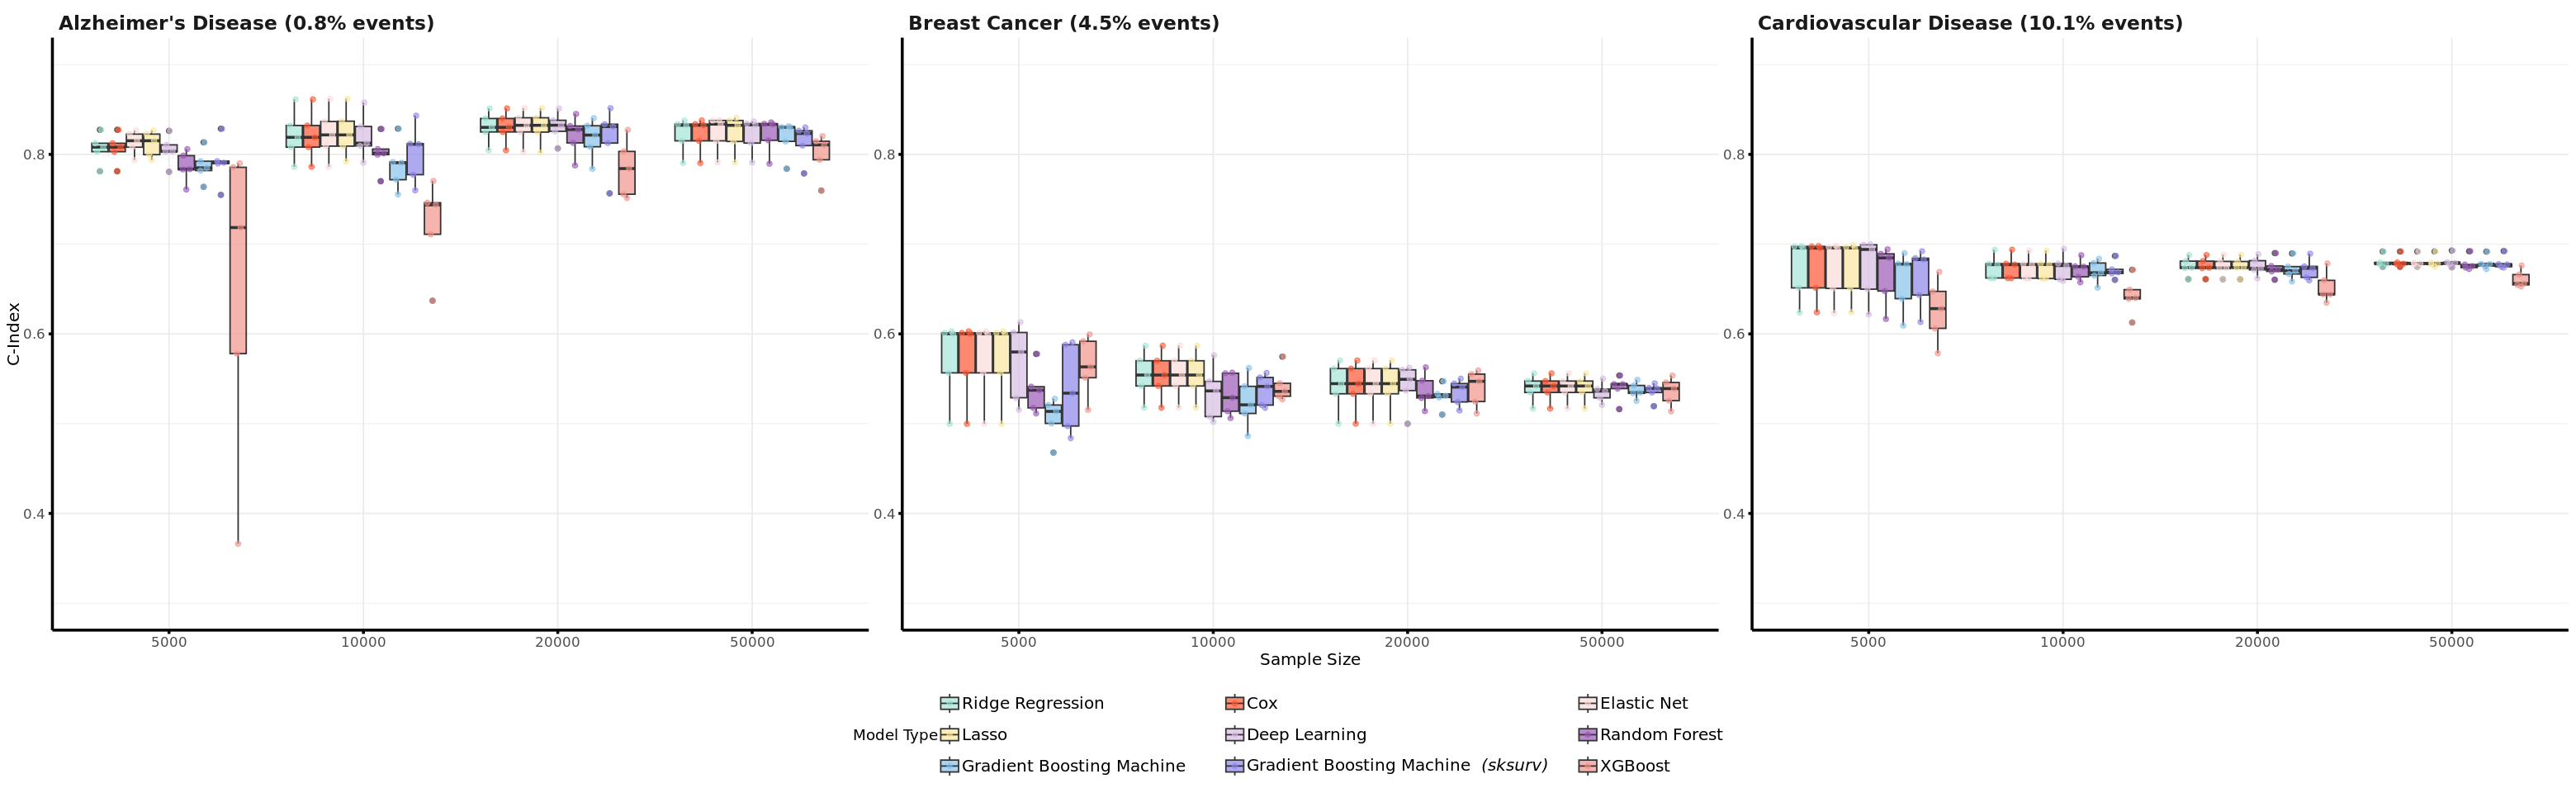

[1] "clinicalrisk"
[1] "everything"


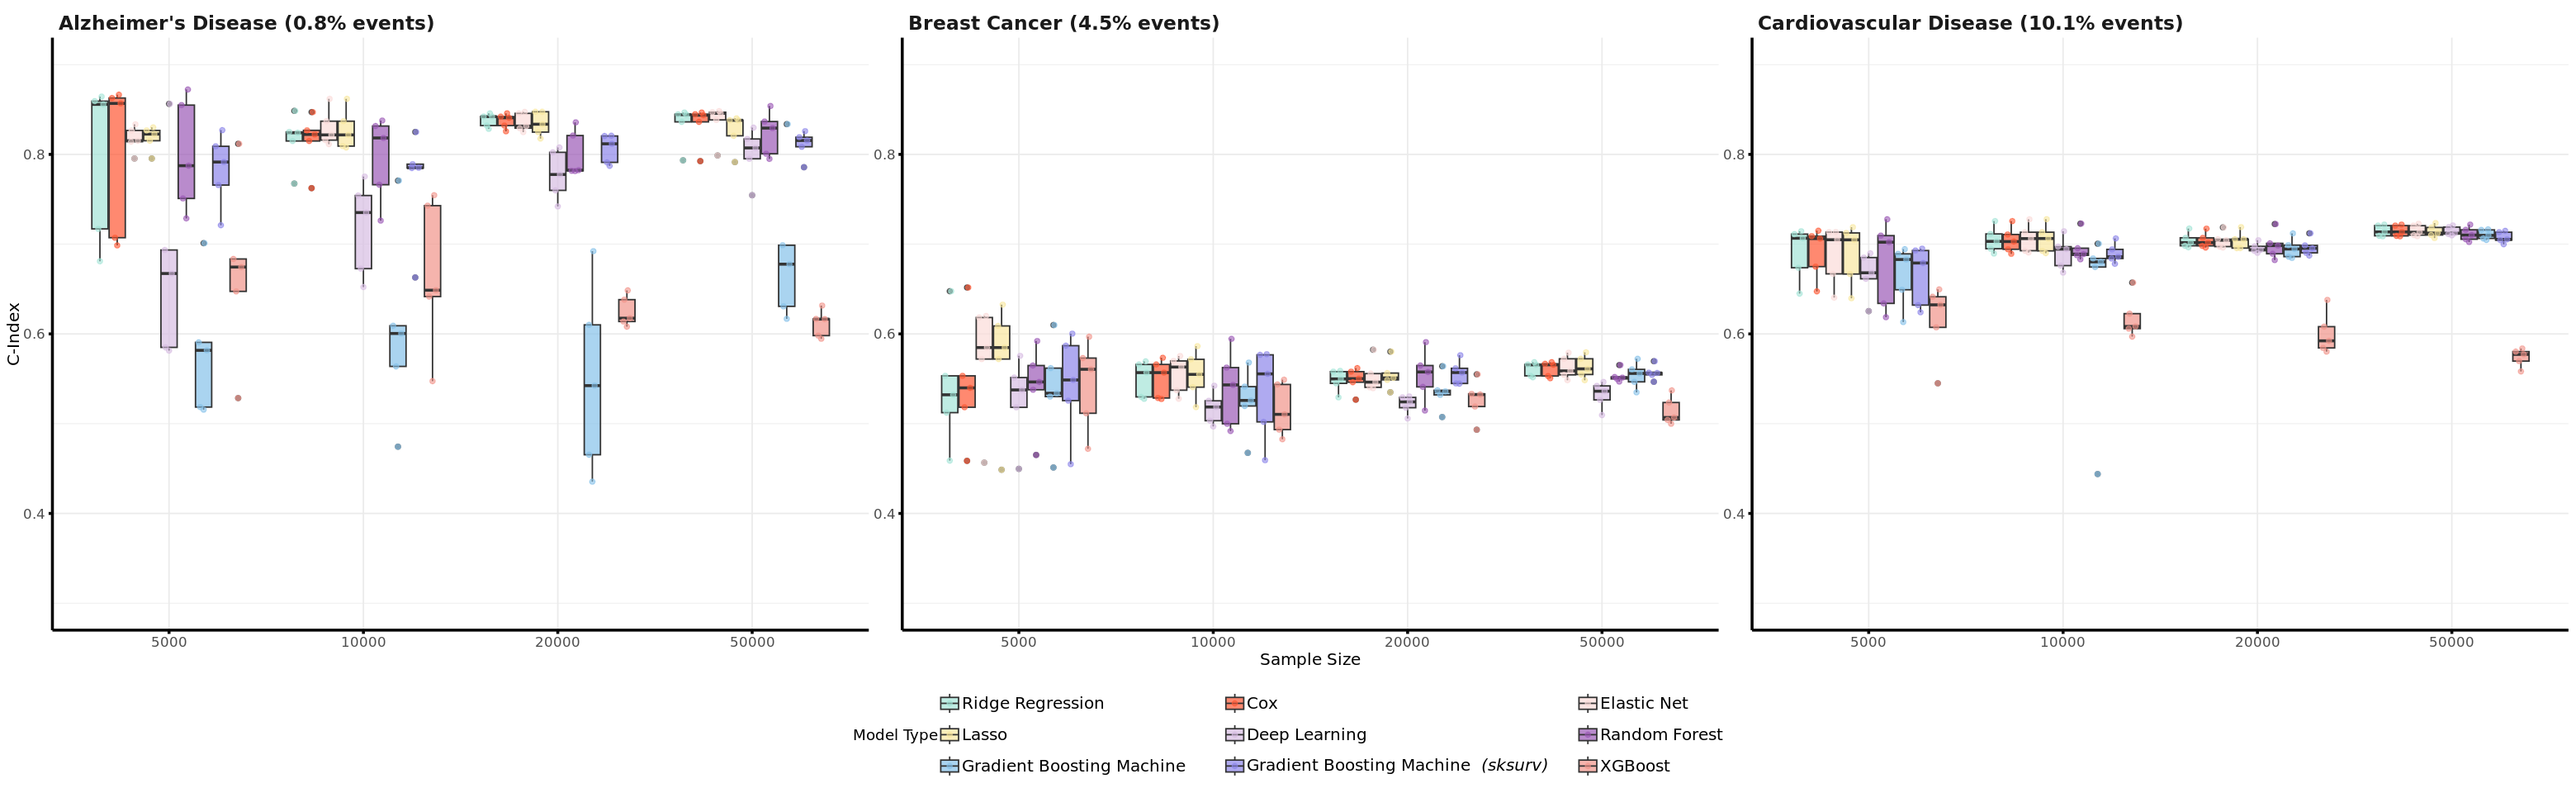

[1] "everything"
[1] "pmh"


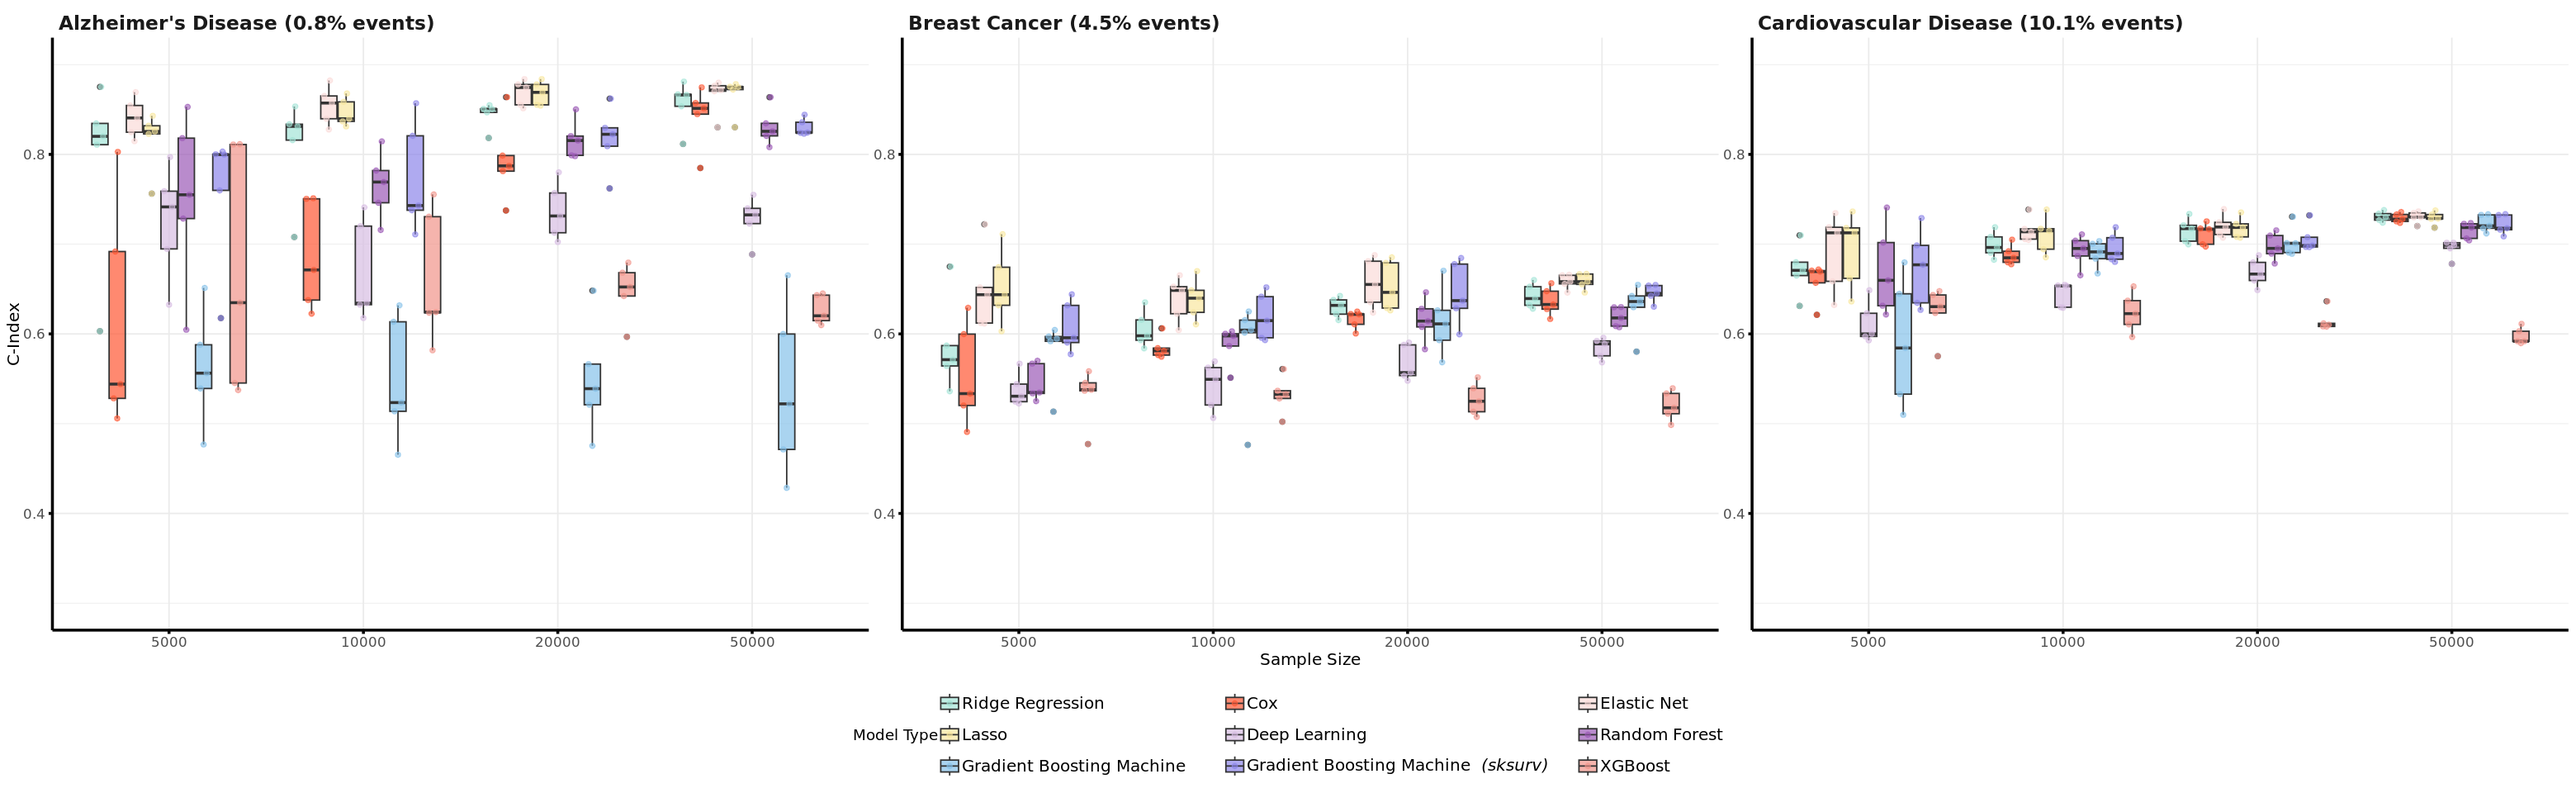

[1] "pmh"
[1] "prs_metabolomics"


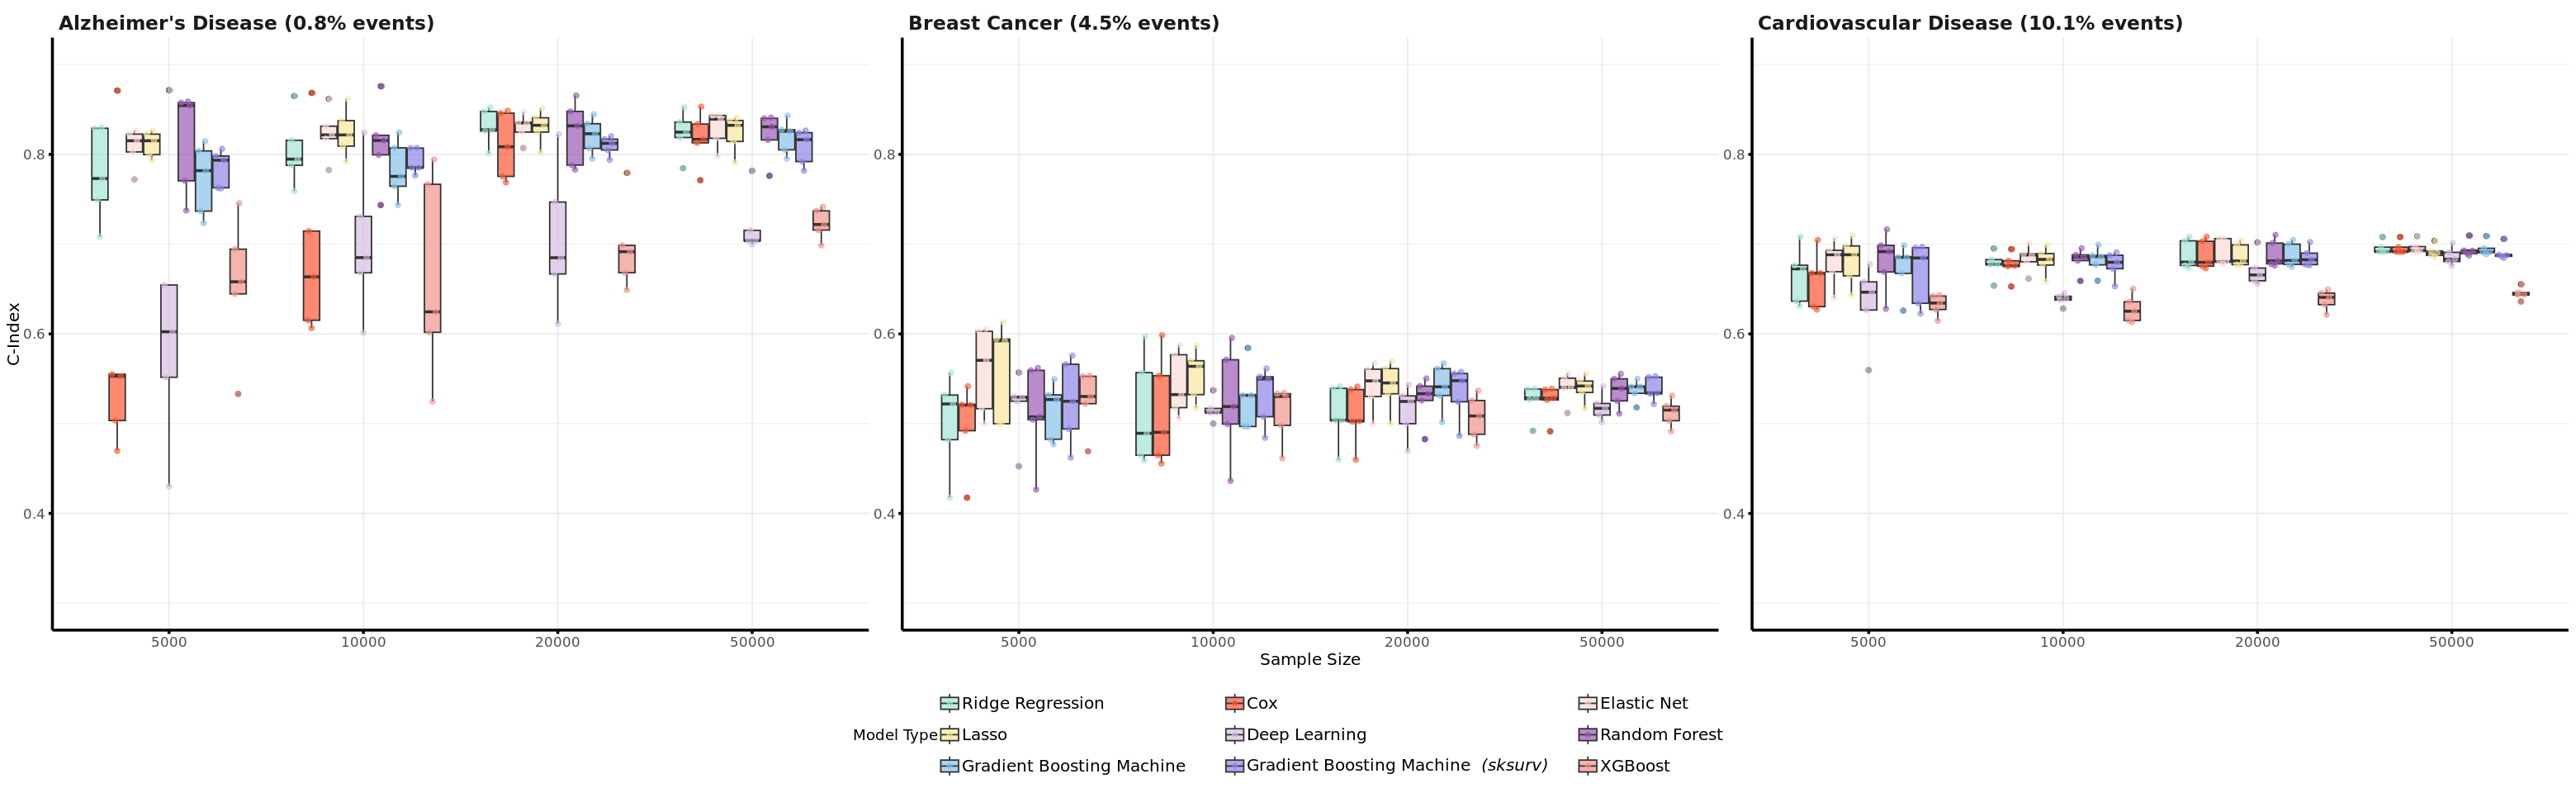

[1] "prs_metabolomics"


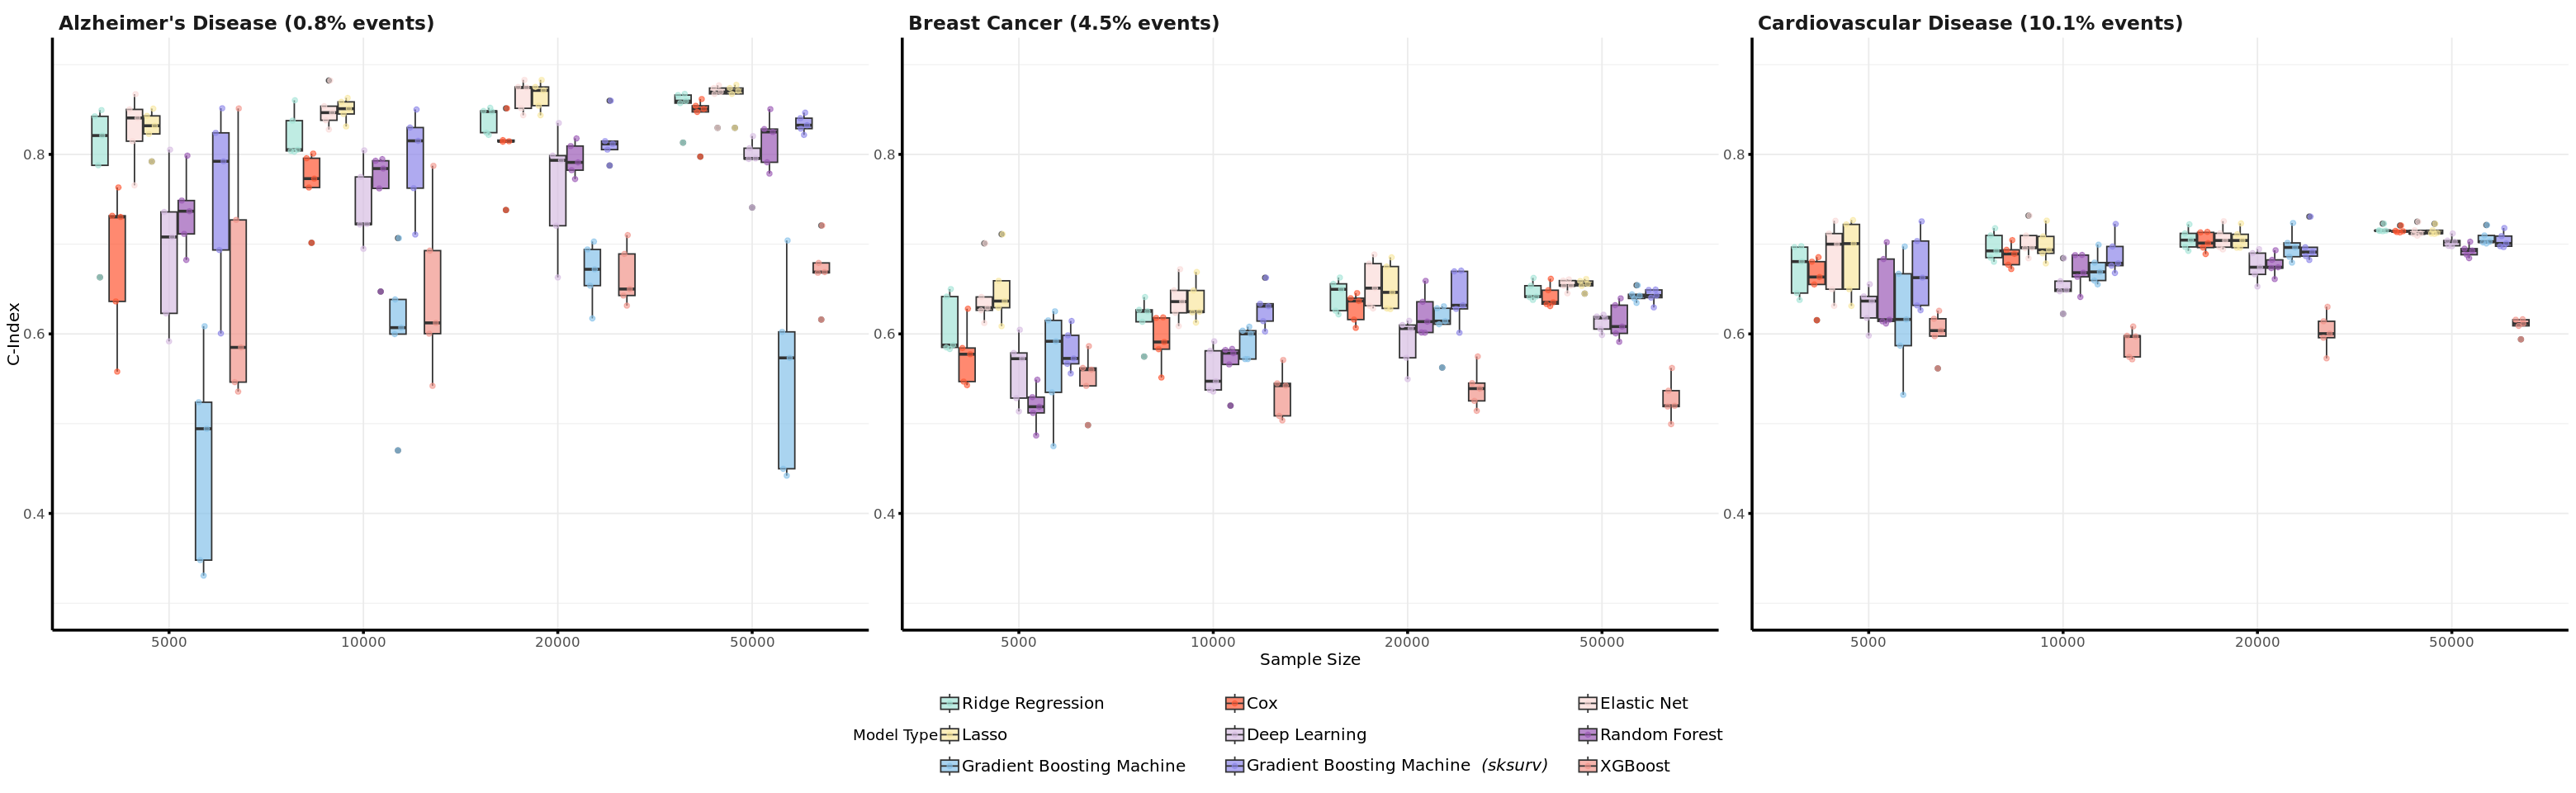

In [27]:
# Adjust plot size for three subplots in one row
options(repr.plot.width = 26, repr.plot.height = 8)

# define the recoding of endpoints
# endpoint_recode <- c(
#                       "CVD" = "Cardiovascular Disease",
#                       "AD"  = "Alzheimer's Disease", 
#                       "BC"  = "Breast Cancer"
#     )

# Define the recoding of model_type
model_type_recode <- c(
  "DL"        = "Deep Learning",
  "EN"        = "Elastic Net",
  "Lasso"     = "Lasso",
  "GBM"       = "Gradient Boosting Machine (sksurv)",
  "lightGBM"  = "Gradient Boosting Machine",
  "RangerRF"  = "Random Forest",
  "Ridge"     = "Ridge Regression",
  "XGB"       = "XGBoost"
)

# Define the custom colors for models
model_colors <- c(
  "Cox"                                = "#FF5733",  # Distinct color for Cox
  "Ridge Regression"                   = "#A3E4D7",
  "Elastic Net"                        = "#FADBD8",
  "Lasso"                              = "#F9E79F",
  "Deep Learning"                      = "#D7BDE2",
  "Random Forest"                      = "#9B59B6",
  "Gradient Boosting Machine"          = "#85C1E9",
  "Gradient Boosting Machine (sksurv)" = "#8c85e9",
  "XGBoost"                            = "#F1948A"
)

# Define the desired order of model types
model_order <- c(
  "Ridge Regression", "Cox", "Elastic Net", "Lasso", 
  "Deep Learning", "Random Forest", 
  "Gradient Boosting Machine", "Gradient Boosting Machine (sksurv)", "XGBoost"
)

# Define the labels, with "(sksurv)" in italic
# Use expression to format the label
model_labels <- c(
  "Ridge Regression"                   = "Ridge Regression",
  "Cox"                                = "Cox",
  "Elastic Net"                        = "Elastic Net",
  "Lasso"                              = "Lasso",
  "Deep Learning"                      = "Deep Learning",
  "Random Forest"                      = "Random Forest",
  "Gradient Boosting Machine"          = "Gradient Boosting Machine",
  "Gradient Boosting Machine (sksurv)" = expression("Gradient Boosting Machine "~italic("(sksurv)")),
  "XGBoost"                            = "XGBoost"
)

# Get unique combo_names from your data
combo_names <- unique(final_performance_df$combo_name)

# Loop over each combo_name to create and save plots
for (combo in combo_names) {
  # if (combo!="everything") next
  # 1) Filter data for the current combo_name
  plot_df <- final_performance_df %>%
    filter(combo_name == combo) %>%
    mutate(
      # Recode model_type names using the provided mapping
      model_type = recode(model_type, !!!model_type_recode),
      endpoint = recode(endpoint,
        "CVD" = "Cardiovascular Disease (10.1% events)",
        "BC"  = "Breast Cancer (4.5% events)",
        "AD"  = "Alzheimer's Disease (0.8% events)"
      )
    )
  
  # Check if there is data for the current combo_name
  if (nrow(plot_df) == 0) {
    next  # Skip to the next combo_name if no data
  }
  
  # Ensure c_index is numeric and cleaned (if not already done)
  plot_df$c_index <- as.numeric(gsub("tensor\\(|\\)", "", plot_df$c_index))
  plot_df$c_index <- round(plot_df$c_index, 4)
  
  # Ensure samplesize is a factor for plotting purposes
  plot_df$samplesize <- factor(plot_df$samplesize, levels = c(5000, 10000, 20000, 50000))
  
  # **Compute combined y-axis limits for all endpoints**
  y_limits <- range(plot_df$c_index, na.rm = TRUE)
  margin <- 0.05 * diff(y_limits)
  y_limits <- c(0.3, 0.9)
  # Ensure y_limits are within 0.5 and 1 (since c-index typically ranges between 0.5 and 1)
  y_limits[1] <- max(0.3, y_limits[1])
  y_limits[2] <- min(1, y_limits[2])

  # 2) Summarize performance by endpoint, model_type, and samplesize
  summary_df <- plot_df %>%
    group_by(endpoint, model_type, samplesize) %>%
    summarise(
      mean_c_index = mean(c_index, na.rm = TRUE),
      sd_c_index   = sd(c_index, na.rm = TRUE),
      .groups = "drop"
    )
  
  # 3) Reorder the factor levels of model_type according to the specified order
  plot_df$model_type <- factor(
    plot_df$model_type,
    levels = model_order
  )
  summary_df$model_type <- factor(
    summary_df$model_type,
    levels = model_order
  )
  
  # 4) Create the plot with three subplots in one row (one for each endpoint)
  f1b <- ggplot(plot_df, aes(x = samplesize, y = c_index, fill = model_type)) +
    geom_boxplot(
      position = position_dodge(width = 0.8),
      alpha = 0.7
    ) +
    # Add jittered points for individual data points
    geom_quasirandom(
      aes(color = model_type),
      dodge.width = 0.8,
      size = 1.5,
      alpha = 0.6
    ) +
    # Overlay mean points from summary_df
    # geom_point(
    #   data = summary_df,
    #   aes(x = samplesize, y = mean_c_index, group = model_type, color = model_type),
    #   position = position_dodge(width = 0.8),
    #   size = 3,
    #   shape = 18
    # ) +
    # **Fix the y-axis scales across facets**
    facet_wrap(~ endpoint, nrow = 1, scales = "free") +  # Default scales are fixed
    # **Apply the computed y-axis limits**
    scale_y_continuous(limits = y_limits) +
    scale_fill_manual(values = model_colors, labels = model_labels, drop = FALSE,
                      guide = guide_legend(nrow = 5, byrow = TRUE)) +
    scale_color_manual(values = model_colors, labels = model_labels, drop = FALSE,
                       guide = guide_legend(nrow = 5, byrow = TRUE)) +
    labs(
      # title = paste("Model Performance Across Sample Sizes -", combo),
      x     = "Sample Size",
      y     = "C-Index",
      fill  = "Model Type",
      color = "Model Type"
    ) +
    theme_minimal() +
    theme(
      legend.position  = "bottom",
      legend.title     = element_text(size = 11),
      legend.text      = element_text(size = 10),
      # legend.text      = element_markdown(),
      axis.line = element_line(color = "black", size = 1),
      axis.ticks = element_line(color = "black", size = 1),
      axis.text.x      = element_text(angle = 0, hjust = 0.5, size = 10),
      axis.title.x     = element_text(size = 12),
      axis.text.y      = element_text(size = 10),
      axis.title.y     = element_text(size = 12),
      strip.text       = element_text(size = 14, face = "bold", hjust=0)
    ) +
    # Parse the expressions in the legend labels
    guides(
      fill = guide_legend(ncol = 3, byrow = TRUE,
                          label.theme = element_text(size = 12, face = "plain", margin= margin(r=40, unit="pt"))),
      color = guide_legend(ncol = 3, byrow = TRUE,
                           label.theme = element_text(size = 12, face = "plain"))
    )
  
  # Print the plot for the current combo_name
  print(combo)
  print(f1b)
  ggsave(
    filename = paste("f4_a_performance_", combo, ".svg", sep = ""),   
    plot = f1b,                  
    width = 24, height = 8,                     
    dpi = 1000,
    bg = "transparent" 
  )

  uplcmd <- paste("dx upload f4_a_performance_", combo, ".svg --path Benchmarking/Plots/f4_a_performance_", combo, ".svg", sep = "")
  system(uplcmd)
  print(combo)
}

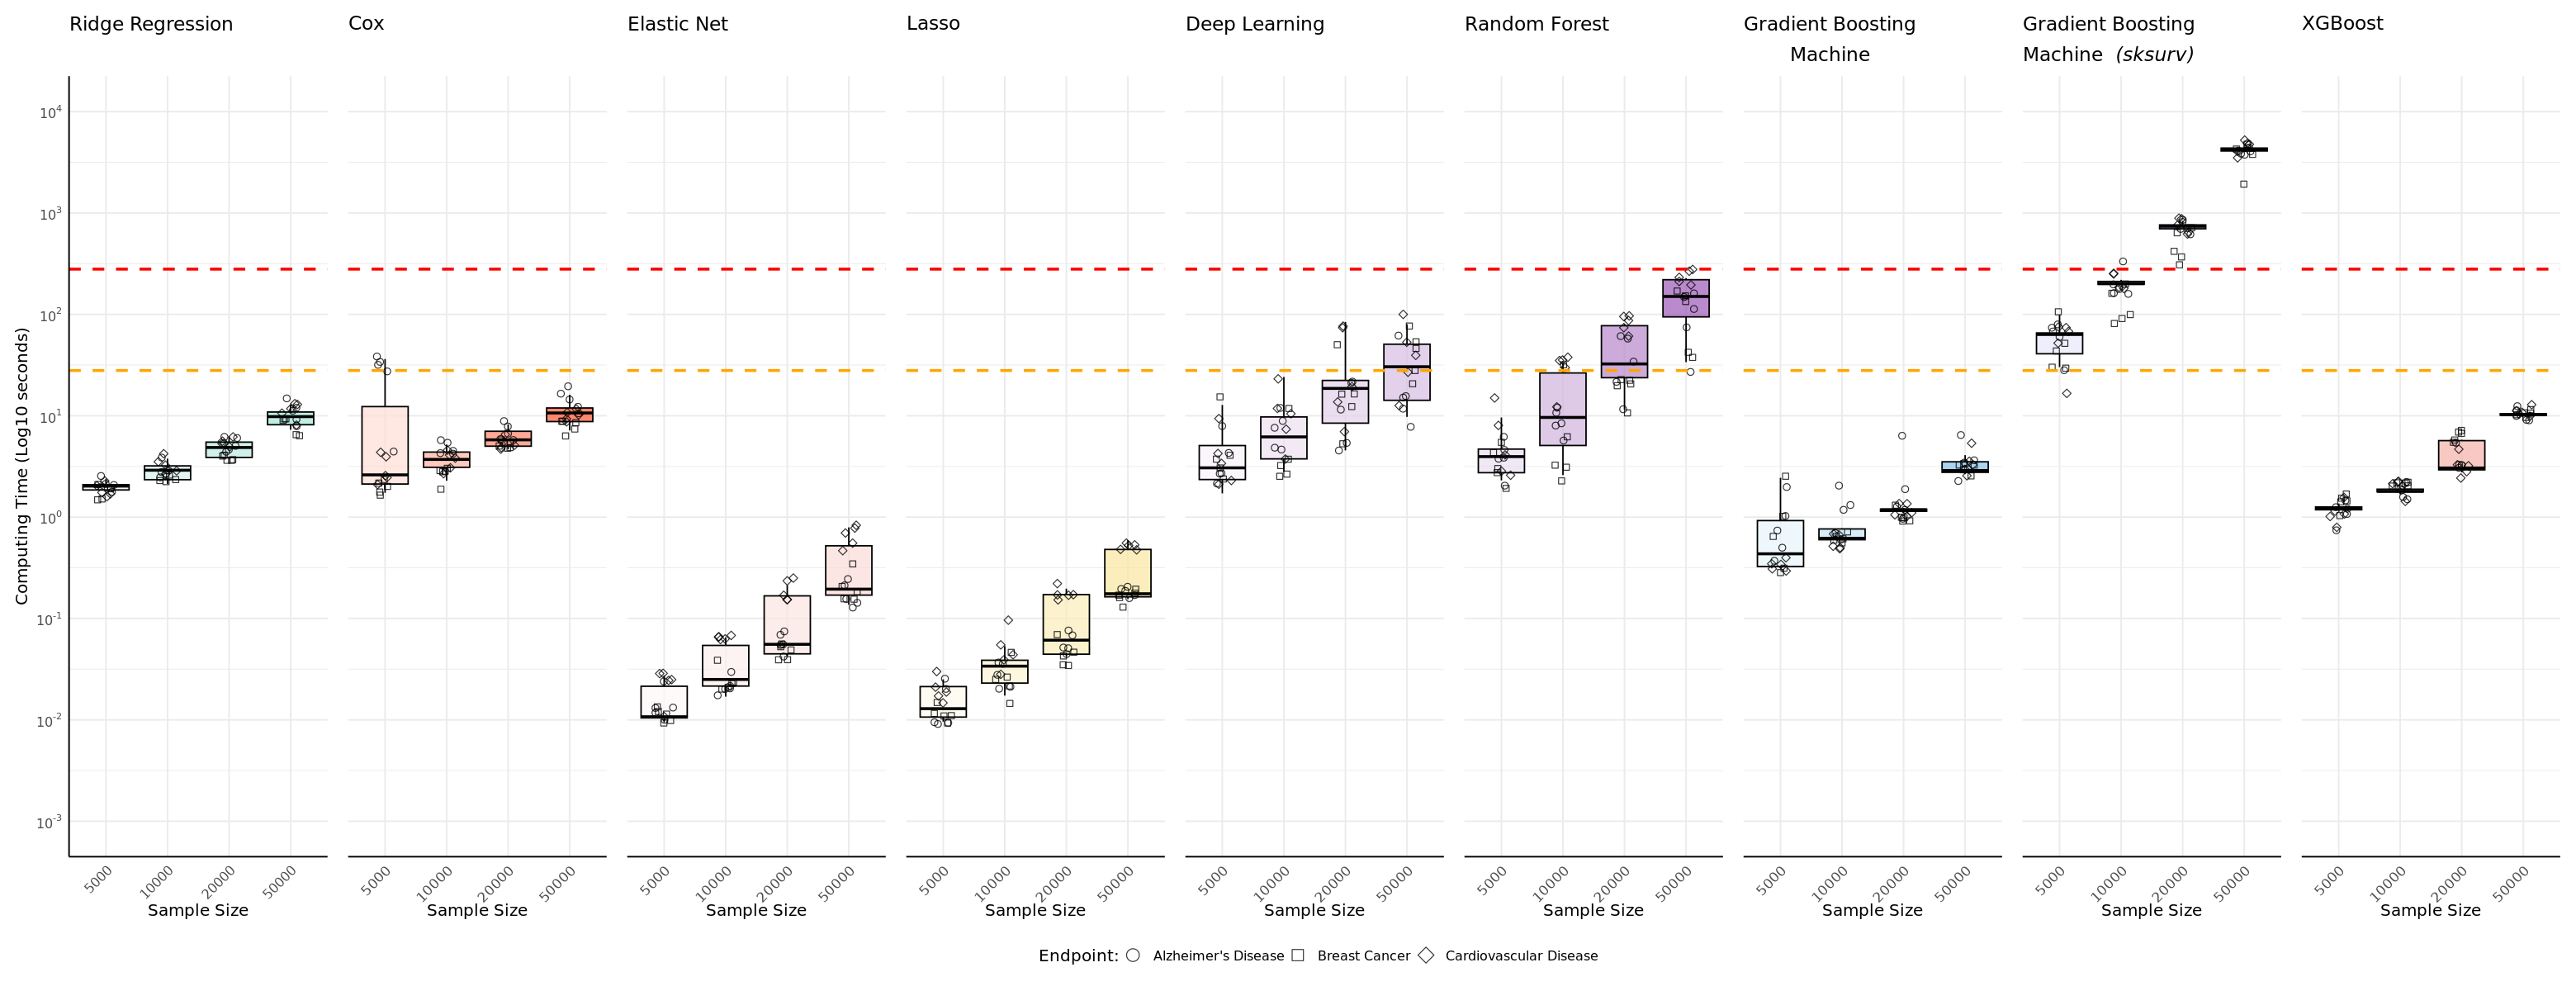

In [40]:
library(dplyr)
library(ggplot2)
library(ggbeeswarm)
library(patchwork)

options(repr.plot.width = 26, repr.plot.height = 10)

combo_namee = "prs_metabolomics"

# define the recoding of endpoints
endpoint_recode <- c(
                      "CVD" = "Cardiovascular Disease",
                      "AD"  = "Alzheimer's Disease", 
                      "BC"  = "Breast Cancer"
    )

# Define recoding of model_type
model_type_recode <- c(
  "DL"        = "Deep Learning",
  "EN"        = "Elastic Net",
  "Lasso"     = "Lasso",
  "GBM"       = "Gradient Boosting Machine (sksurv)",
  "lightGBM"  = "Gradient Boosting Machine",
  "RangerRF"  = "Random Forest",
  "Ridge"     = "Ridge Regression",
  "XGB"       = "XGBoost"
)

# Desired order of model types
model_order <- c(
  "Ridge Regression", "Cox", "Elastic Net", "Lasso", 
  "Deep Learning", "Random Forest", 
  "Gradient Boosting Machine", "Gradient Boosting Machine (sksurv)", "XGBoost"
)

# Labels for model types
model_labels <- c(
  "Ridge Regression"                   = "Ridge Regression",
  "Cox"                                = "Cox",
  "Elastic Net"                        = "Elastic Net",
  "Lasso"                              = "Lasso",
  "Deep Learning"                      = "Deep Learning",
  "Random Forest"                      = "Random Forest",
  "Gradient Boosting Machine"          = expression(atop("Gradient Boosting", "Machine")),
  "Gradient Boosting Machine (sksurv)" = expression(atop("Gradient Boosting", "Machine "~italic("(sksurv)"))),
  "XGBoost"                            = "XGBoost"
)

# Manual color assignment for each model type (Cox model highlighted)
model_colors <- c(
  "Cox"                                = "#FF5733",  # Distinct color for Cox
  "Ridge Regression"                   = "#A3E4D7",
  "Elastic Net"                        = "#FADBD8",
  "Lasso"                              = "#F9E79F",
  "Deep Learning"                      = "#D7BDE2",
  "Random Forest"                      = "#9B59B6",
  "Gradient Boosting Machine"          = "#85C1E9",
  "Gradient Boosting Machine (sksurv)" = "#8c85e9",
  "XGBoost"                            = "#F1948A"
)


# Helper function to generate lighter shades of a base color
generate_shades <- function(base_color, n) {
  # Proportions for mixing with white (from 70% base color to 100%)
  proportions <- seq(0.2, 1, length.out = n)
  
  # Function to mix base color with white
  mix_with_white <- function(color, proportion) {
    rgb_color <- col2rgb(color) / 255  # Convert to 0-1 range
    mixed_color <- rgb_color * proportion + 1 * (1 - proportion)  # Mix with white
    rgb(mixed_color[1], mixed_color[2], mixed_color[3])
  }
  
  # Generate shades
  shades <- sapply(proportions, function(p) mix_with_white(base_color, p))
  
  return(shades)
}

# Recode model types in the dataset
timings_df <- final_timings_df[final_timings_df$combo_name==combo_namee,] %>%
  mutate(
    model_type = recode(model_type, !!!model_type_recode),
    endpoint = recode(endpoint, !!!endpoint_recode),
    sample_size = factor(sample_size),
    once_time = as.numeric(gsub("tensor\\(|\\)", "", once_time)),
    log_once_time = log10(once_time)
  )

# Global Y-axis Limits
global_min_log_time <- -3  # Corresponding to 0.001
global_max_log_time <- 4   # Corresponding to 10000

# Shapes for endpoints
unique_endpoints <- unique(timings_df$endpoint)
shape_values <- c(21, 22, 23, 24, 25)[seq_along(unique_endpoints)]
names(shape_values) <- unique_endpoints

# Define model types for plotting
model_types <- model_order
plots_per_row <- 9

# Define a helper function to conditionally set y-axis labels
get_y_label <- function(index, plots_per_row) {
  if ((index %% plots_per_row) == 1) {
    return ("Computing Time (Log10 seconds)")
  } else {
    return ("" )
  }
}
                   
# Define cost_per_hour and calculate corresponding compute time thresholds
cost_per_hour <- 1.2876  # GBP per hour

compute_time_threshold1 <- (0.1 / cost_per_hour) * 3600  # seconds
log_threshold1 <- log10(compute_time_threshold1)       

compute_time_threshold2 <- (0.01 / cost_per_hour) * 3600  # seconds
log_threshold2 <- log10(compute_time_threshold2)    

plot_list <- list()  # Initialize plot list if not already defined

for (i in seq_along(model_types)) {
    model <- model_types[i]
    
    # Subset data for the current model_type
    subset_timings <- timings_df %>% filter(model_type == model)

    # Generate shades for sample_size based on model_type's base color
    base_color <- model_colors[as.character(model)]
    sample_shades <- generate_shades(base_color, length(unique(subset_timings$sample_size)))
    names(sample_shades) <- levels(subset_timings$sample_size)

    # Create the plot with shaded boxplots
    p <- ggplot(subset_timings, aes(x = sample_size, y = log_once_time)) +
      geom_boxplot(aes(fill = sample_size),
                   color = "black",
                   alpha = 0.7,
                   outlier.shape = NA) +
      geom_jitter(aes(shape = endpoint),
                  color = "black",
                  stroke = 0.5,
                  size = 2,
                  alpha = 0.8,
                  width = 0.15,
                  height = 0.1) +
    geom_hline(
      yintercept = log_threshold1,
      color = "red",
      linetype = "dashed",
      size = 1
    ) +
    geom_hline(
      yintercept = log_threshold2,
      color = "orange",
      linetype = "dashed",
      size = 1
    ) +
      scale_y_continuous(limits = c(global_min_log_time, global_max_log_time),
                         breaks = seq(global_min_log_time, global_max_log_time, by = 1),
                         labels = scales::math_format(10^.x)) +
      scale_fill_manual(values = sample_shades, guide = "none") +  # Hide the sample_size legend
      scale_shape_manual(values = shape_values) +
      labs(title = model_labels[as.character(model)],
           x = "Sample Size",
           y = get_y_label(i, plots_per_row)) +
      theme_minimal(base_size = 12) +
      theme(
        axis.text.x = element_text(angle = 45, hjust = 1),
        plot.title = element_text(size = 14, face = "bold", hjust = 0),  # Left-align title
        axis.line.x = element_line(color = "black"),  # Black x-axis line
        legend.position = "none"
      )
  
    if ((i - 1) %% plots_per_row == 0) {
      # Black y-axis line only for the leftmost plots
      p <- p + theme(axis.line.y = element_line(color = "black"))
    } else {
      p <- p + theme(
        axis.text.y = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
      )
    }

    plot_list[[i]] <- p
}

# Combine plots in a grid layout with a shared legend
combined_plot <- wrap_plots(plotlist = plot_list, ncol = plots_per_row) +
  plot_layout(guides = "collect") &
  theme(legend.position = "bottom")

# Set up a shared legend for endpoints below all the plots
combined_plot <- combined_plot & guides(shape = guide_legend(
  override.aes = list(fill = NA, size = 4),
  title = "Endpoint: "
))

# Print the combined plot with endpoint legend at the bottom
print(combined_plot)
                   
                   
ggsave(
filename = paste("f4_b_computingtime_", combo_namee, ".svg", sep = ""),   
plot = combined_plot,                    
width = 24, height = 8,                       
dpi = 1000,
bg = "transparent" 
)

uplcmd <- paste("dx upload f4_b_computingtime_", combo_namee, ".svg --path Benchmarking/Plots/f4_b_computingtime_", combo_namee, ".svg", sep = "")
system(uplcmd)